# Disease-state discovery on HLCA - prepare datasets

In this notebook we compare reference designs for disease-state identification on the dataset from [Adams et al](https://www.science.org/doi/10.1126/sciadv.aba1983), using trained models from the [Human Lung Cell Atlas](https://www.biorxiv.org/content/10.1101/2022.03.10.483747v1.full). 

- Model repository: https://zenodo.org/record/6337966/#.Yzv65ezMK3J
- Extended HLCA data objects: https://beta.fastgenomics.org/datasets/detail-dataset-427f1eee6dd44f50bae1ab13f0f3c6a9#Files


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import oor_benchmark

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(tidyverse)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


## Download data and trained models 

From Zenodo repository

In [3]:
%%bash
cd /lustre/scratch117/cellgen/team205/ed6/HLCA/

## Download extended HLCA embeddings 
if ! [ -d Kaminski_2020_emb_LCAv2.h5ad ];
    then echo "Downloading scArches embeddings from zenodo"
    wget -nv https://zenodo.org/record/6337966/files/HLCA_extended_models_and_embs.zip
    unzip HLCA_extended_models_and_embs.zip
    rm HLCA_extended_models_and_embs.zip
fi

2022-10-04 09:55:03 URL:https://zenodo.org/record/6337966/files/HLCA_extended_models_and_embs.zip [380368487/380368487] -> "HLCA_extended_models_and_embs.zip" [1]


Archive:  HLCA_extended_models_and_embs.zip
   creating: HLCA_extended_models_and_embs/
   creating: HLCA_extended_models_and_embs/surgery_output_embeddings/
   creating: HLCA_extended_models_and_embs/surgery_models/
  inflating: HLCA_extended_models_and_embs/surgery_output_embeddings/KULeuven_Thienpont_2018Lambrechts_v2_emb_LCAv2.h5ad  
  inflating: HLCA_extended_models_and_embs/surgery_output_embeddings/Sims_2019_emb_LCAv2.h5ad  
  inflating: HLCA_extended_models_and_embs/surgery_output_embeddings/Lafyatis_Rojas_2019_disease_emb_LCAv2.h5ad  
  inflating: HLCA_extended_models_and_embs/surgery_output_embeddings/Budinger_2021_emb_LCAv2.h5ad  
  inflating: HLCA_extended_models_and_embs/surgery_output_embeddings/Shalek_2018_emb_LCAv2.h5ad  
  inflating: HLCA_extended_models_and_embs/surgery_output_embeddings/Wunderink_2021_cryo_emb_LCAv2.h5ad  
  inflating: HLCA_extended_models_and_embs/surgery_output_embeddings/Eils_2020_emb_LCAv2.h5ad  
  inflating: HLCA_extended_models_and_embs/surgery

## Prepare ACR design

Use control and condition mapped to HLCA core (from original pub). Full gene expression matrix was downloaded from the original publication.

In [ ]:
# Objects processed by Amanda
datadir = '/lustre/scratch117/cellgen/team205/ed6/HLCA/'
h5ad_file = '/nfs/team205/ao15/Adult_lung_MadissoonOliver/Kaminski2020_COPD/Kaminski_2020_HLCAlabeltransfer.h5ad'
adata = sc.read_h5ad(h5ad_file, backed=False)
adata_hlca = sc.read_h5ad(datadir + "Kaminski_2020_emb_LCAv2.annotated.h5ad", backed=True)
## Keep cells analysed in HLCA
adata = adata[adata_hlca.obs_names.str.strip("_adams")].copy()
adata.obsm = adata_hlca.obsm.copy()
adata.obsp = adata_hlca.obsp.copy()
adata.write_h5ad(datadir + "Kaminski_2020_emb_LCAv2.annotated.with_counts.h5ad")

In [73]:
datadir = '/lustre/scratch117/cellgen/team205/ed6/HLCA/'
adata = sc.read_h5ad(datadir + "Kaminski_2020_emb_LCAv2.annotated.with_counts.h5ad")

## Set IDs to var_names
adata.var['gene_name'] = adata.var.index.values
adata.var_names = adata.var['Ensembl_GeneID']

## Renamer
rename_obs_cols = {
    'Library_Identity':'sample',
    'Subject_Identity':'individual', 
    'Disease_Identity':'disease'
}

adata.obs = adata.obs.rename(rename_obs_cols, axis=1)

## Get label uncertainty from original HLCA study
full_file = '/lustre/scratch117/cellgen/team205/ed6/HLCA/HLCA_v1_extended_raw_counts_2000hvgs.h5ad' ## Downloaded from FastGenomics
full_adata = sc.read_h5ad(full_file, backed='r')

adata.obs['HLCA_label_transfer_uncertainty']  = full_adata.obs.loc[adata.obs_names + "_adams"]['ext_transf_uncert_level_5'].values

## Add labels to train scANVI model for CR design
adata.obs['scanvi_labels'] = full_adata.obs.loc[adata.obs_names + "_adams"]['original_ann_level_2'].values

Save ACR design object

In [79]:
adata.write_h5ad(data_dir + "Kaminski_2020_oor_design.ACR.h5ad")

In [44]:
full_adatair = '/lustre/scratch117/cellgen/team205/ed6/HLCA/'
# emb_file = '/lustre/scratch117/cellgen/team205/ed6/HLCA/HLCA_extended_models_and_embs/surgery_output_embeddings/Kaminski_2020_emb_LCAv2.h5ad'
# full_file = '/lustre/scratch117/cellgen/team205/ed6/HLCA/HLCA_v1_extended_raw_counts_2000hvgs.h5ad' ## Downloaded from FastGenomics
# full_adata = sc.read_h5ad(full_file, backed='r')

# query_adata = sc.read_h5ad(emb_file)

# ## Get obs for Kaminski_2020
# query_adata.obs = full_adata.obs[full_adata.obs_names.isin(query_adata.obs_names)].copy()

# ## Exclude cols that are all NAs for this dataset
# non_na_obs_columns = query_adata.obs.columns[
#     ((query_adata.obs == 'nan').sum() < query_adata.n_obs) &
#     (query_adata.obs.isna().sum() < query_adata.n_obs)
# ].tolist()

# ## Remove obs that are the same for all cells
# ## (move to uns)
# dataset_meta = {}
# keep_obs_columns = []
# for col in non_na_obs_columns:
#     if query_adata.obs[col].unique().shape[0] == 1:
#         dataset_meta[col] = query_adata.obs[col].unique()[0]
#     else:
#         keep_obs_columns.append(col)
        
# ## Remove HLCA analysis columns
# keep_obs_columns = [x for x in keep_obs_columns if not x.startswith('ext_transf')]

# ## Keep column for label transfer uncertainty score used in HLCA ms
# keep_obs_columns.append('ext_transf_uncert_level_5')


# query_adata.obs = query_adata.obs[keep_obs_columns].copy()
# for c in query_adata.obs.columns:
#     if query_adata.obs[c].dtype == 'category':
#         query_adata.obs[c] = query_adata.obs[c].cat.remove_unused_categories()
# query_adata.obsm['X_scVI'] = query_adata.X.copy()
# query_adata.uns['dataset_metadata'] = dataset_meta.copy()

# ## Renamer
# rename_obs_cols = {
#     'subject_ID':'individual', 
#     'condition':'disease', 
#     'ext_transf_uncert_level_5':'HLCA_label_transfer_uncertainty'
# }

# query_adata.obs = query_adata.obs.rename(rename_obs_cols, axis=1)

# ## Read gene expression matrix (downloaded from original pub)
# adata_gex = sc.read_h5ad('/nfs/team205/ao15/Adult_lung_MadissoonOliver/Kaminski2020_COPD/Kaminski_2020_HLCAlabeltransfer.h5ad')

# query_adata.X = adata_gex[query_adata.obs_names.str.strip("_adams")].X.copy()
# query_adata.obs['Celltype_HLCA'] = adata_gex[query_adata.obs_names.str.strip("_adams")].obs['Celltype_HLCA'].values

## Prepare AR design

In [6]:
data_dir = '/lustre/scratch117/cellgen/team205/ed6/HLCA/'
acr_adata = sc.read_h5ad(data_dir + "Kaminski_2020_oor_design.ACR.h5ad", backed=True)

In [7]:
full_file = '/lustre/scratch117/cellgen/team205/ed6/HLCA/HLCA_v1_extended_raw_counts_2000hvgs.h5ad' ## Downloaded from FastGenomics
full_adata = sc.read_h5ad(full_file, backed='r')

In [8]:
## Subset to core atlas and Kaminski
keep_obs = full_adata.obs_names[(full_adata.obs['HLCA_core_or_extension'] == 'core') | (full_adata.obs['study'] == 'Kaminski_2020')]
adata = full_adata[keep_obs].to_memory()

## Renamer
rename_obs_cols = {
    'subject_ID':'individual', 
    'condition':'disease', 
    'ext_transf_uncert_level_5':'HLCA_label_transfer_uncertainty'
}

adata.obs = adata.obs.rename(rename_obs_cols, axis=1)

In [17]:
## Store annotation
adata.obs['Celltype_HLCA'] = np.nan
adata.obs.loc[adata.obs['HLCA_core_or_extension'] == 'core', 'Celltype_HLCA'] = adata.obs.loc[adata.obs['HLCA_core_or_extension'] == 'core', 'ann_finest_level']

kaminski_cells = adata.obs_names[adata.obs['HLCA_core_or_extension'] != 'core']
adata.obs.loc[kaminski_cells, 'Celltype_HLCA'] = acr_adata.obs.loc[kaminski_cells.str.strip("_adams"),'Celltype_HLCA'].values

In [18]:
keep_obs = ['individual', 'sample', 'disease', 'study', 'HLCA_core_or_extension', 'Celltype_HLCA', 'HLCA_label_transfer_uncertainty']

In [19]:
adata.obs = adata.obs[keep_obs]

In [20]:
## Store joint embedding
emb_adata = sc.read_h5ad(data_dir + "HLCA_emb_and_metadata.h5ad", backed=False)

X_scVI_core = emb_adata[adata.obs_names[adata.obs['HLCA_core_or_extension'] == 'core']].X.copy()
X_scVI_kaminski = acr_adata[kaminski_cells.str.strip("_adams")].obsm['X_scVI'].copy()

assert all(np.hstack([adata.obs_names[adata.obs['HLCA_core_or_extension'] == 'core'], kaminski_cells]) == adata.obs_names)
adata.obsm['X_scVI'] = np.vstack([X_scVI_core, X_scVI_kaminski])

In [21]:
adata

AnnData object with n_obs × n_vars = 892534 × 2000
    obs: 'individual', 'sample', 'disease', 'study', 'HLCA_core_or_extension', 'Celltype_HLCA', 'HLCA_label_transfer_uncertainty'
    uns: 'ann_finest_level_colors', 'ann_level_1_core_transferred_colors'
    obsm: 'X_umap', 'X_scVI'

In [30]:
## Clean disease assingment
adata.obs['disease'] = np.where(adata.obs['disease'].isin(['healthy', 'nan', 'Control', "Healthy", 'had TB as a child (fully treated over 30+ years)']), 'Control', adata.obs['disease'])
adata.obs['disease'] = adata.obs['disease'].astype("category").cat.reorder_categories(
    ['non-small cell lung cancer', 'carcinoid','worsening respiratory function prior to arrest', "Control",'COPD', 'IPF'])

In [31]:
adata.write_h5ad(data_dir + "Kaminski_2020_oor_design.AR.h5ad")

In [52]:
n_donors = acr_adata.obs[['disease', 'individual']].drop_duplicates().value_counts('disease')
n_cells = acr_adata.obs[['disease', 'individual']].value_counts('disease')
df = pd.concat([n_donors, n_cells], 1)
df.columns = ['n_donors', 'n_cells']
print(df)

         n_donors  n_cells
disease                   
IPF            32   144404
Control        28    95303
COPD           18    67943


/tmp/ipykernel_51420/1809269403.py:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pd.concat([n_donors, n_cells], 1)


In [41]:
print("# cells")


# cells


disease
IPF        144404
Control     95303
COPD        67943
dtype: int64

## Prep CR design

In [158]:
cr_adata = sc.read_h5ad(data_dir + "Kaminski_2020_oor_design.ACR.h5ad", backed=False)

In [171]:
%%bash
cd /lustre/scratch117/cellgen/team205/ed6/HLCA/
wget https://raw.githubusercontent.com/LungCellAtlas/HLCA_reproducibility/main/notebooks/3_atlas_extension/HLCA_extension_data_preprocessing/genes_for_mapping.csv

--2023-01-11 17:44:48--  https://raw.githubusercontent.com/LungCellAtlas/HLCA_reproducibility/main/notebooks/3_atlas_extension/HLCA_extension_data_preprocessing/genes_for_mapping.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45063 (44K) [text/plain]
Saving to: ‘genes_for_mapping.csv.1’

     0K .......... .......... .......... .......... ....      100% 15.7M=0.003s

2023-01-11 17:44:48 (15.7 MB/s) - ‘genes_for_mapping.csv.1’ saved [45063/45063]



In [179]:
## Use the same HVGs used in core
genes_for_mapping = pd.read_csv(data_dir+'genes_for_mapping.csv',index_col=0)
cr_adata.var['mapping_gene'] = cr_adata.var_names.isin(genes_for_mapping.index)

In [190]:
cr_adata.obs['dataset'] = 'Kaminski_2020'

In [215]:
cr_adata.write_h5ad(data_dir + "Kaminski_2020_oor_design.CR.h5ad")

We generate a common latent embedding between control and disease dataset running the script `train_CR_design.py` 

---

### Plot embedding of query dataset

In [131]:
sc.pp.neighbors(query_adata, n_neighbors=100, use_rep='X_scVI')
sc.tl.umap(query_adata)

In [132]:
query_adata.write_h5ad(data_dir + "Kaminski_2020_emb_LCAv2.annotated.h5ad")

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


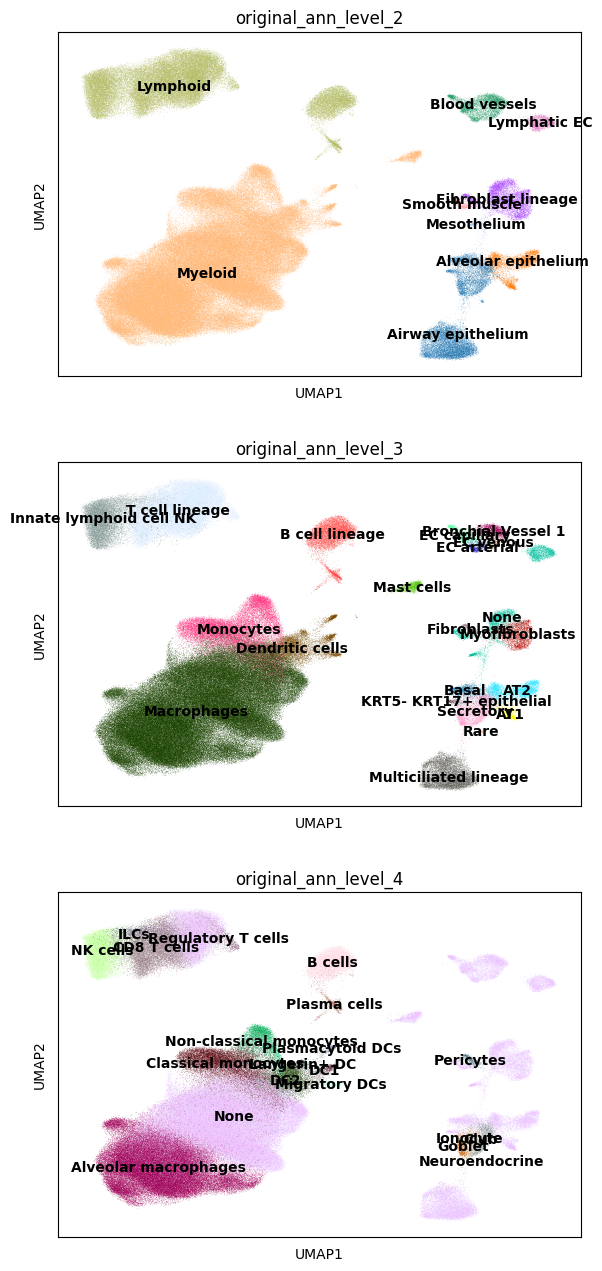

In [138]:
sc.pl.umap(query_adata, color=['original_ann_level_2','original_ann_level_3', 'original_ann_level_4'], legend_loc='on data', ncols=1)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


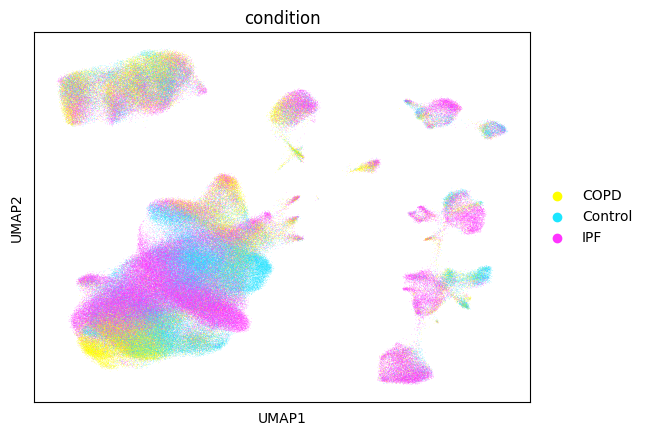

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


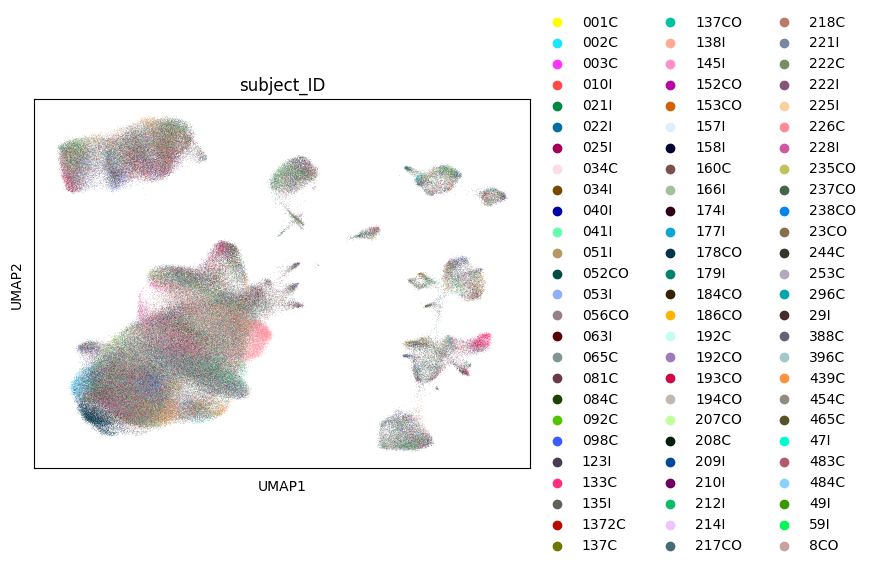

In [145]:
query_adata.obs['condition'] = query_adata.obs['condition'].astype('str').astype("category")
query_adata.obs['subject_ID'] = query_adata.obs['subject_ID'].astype('str').astype("category")
if 'subject_ID_colors' in query_adata.uns:
    del query_adata.uns['subject_ID_colors']
sc.pl.umap(query_adata, color=['condition'], ncols=1)
sc.pl.umap(query_adata, color=['subject_ID'], ncols=1)

## Run differential analysis with milo

In [166]:
from oor_benchmark.methods.scArches_milo import run_milo
import milopy

In [158]:
query_adata.obs['original_ann_combined'] = query_adata.obs[['original_ann_level_2','original_ann_level_3', 'original_ann_level_4']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [235]:
milopy.core.make_nhoods(query_adata, prop=0.01)

In [236]:
query_adata.obs['sample'] = query_adata.obs['sample'].astype('str').astype('category') ## remove unused categories
query_adata.obs['sample_type'] = query_adata.obs['sample_type'].astype('str').astype('category') ## remove unused categories
milopy.core.count_nhoods(query_adata, sample_col='sample')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Text(0.5, 0, 'Nhood size')

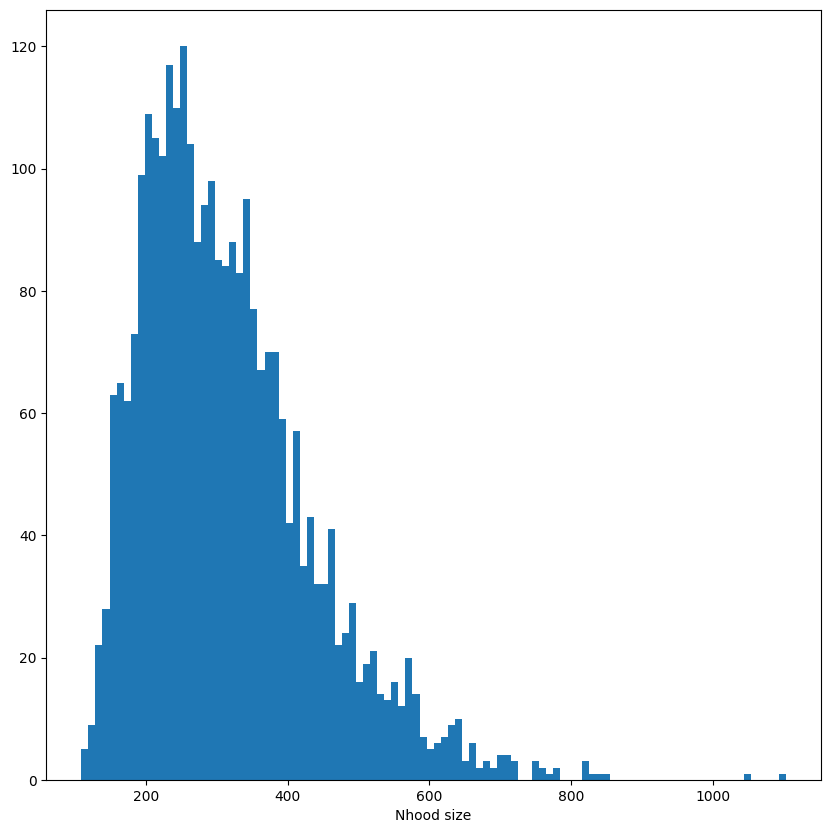

In [237]:
plt.hist(np.array(query_adata.obsm['nhoods'].sum(0)).ravel(), bins=100);
plt.xlabel("Nhood size")

### Test IPF vs Control

In [238]:
milopy.utils.annotate_nhoods(query_adata[query_adata.obs["condition"] == 'Control'], 'original_ann_combined')
# adata_design.obs["is_query"] = adata_design.obs["dataset_group"] == query_group
milopy.core.DA_nhoods(query_adata, design='~condition', model_contrasts='conditionIPF-conditionControl')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


In [239]:
milopy.utils.build_nhood_graph(query_adata)

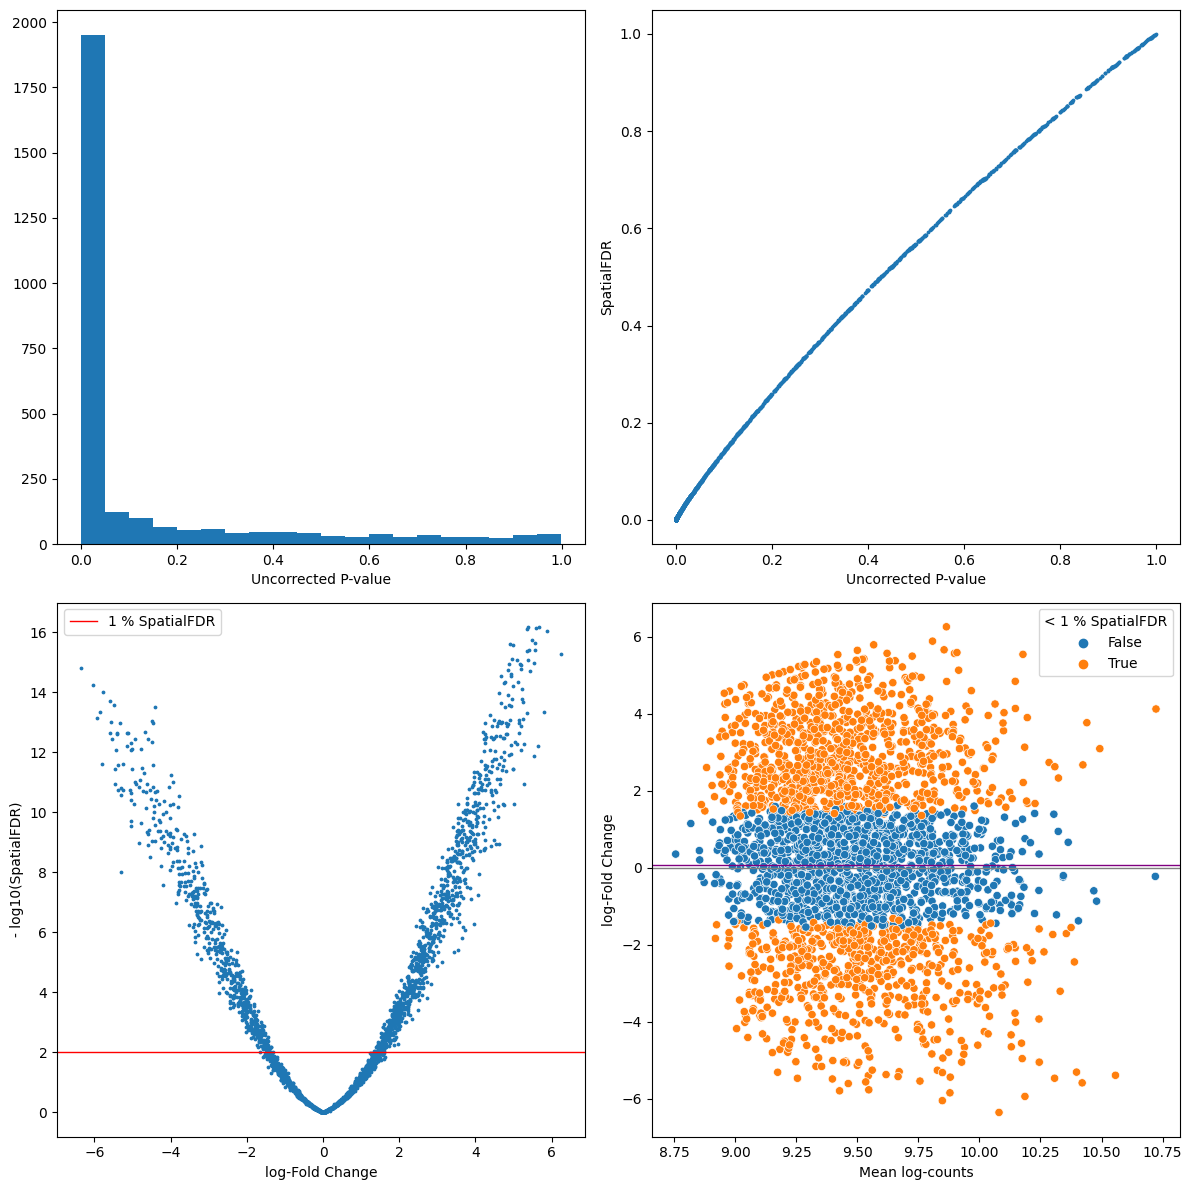

In [240]:
def plot_milo_diagnostics(adata, alpha = 0.1):
    nhood_adata = adata.uns["nhood_adata"].copy()

    with matplotlib.rc_context({"figure.figsize": [12, 12]}):

        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(nhood_adata.obs["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(nhood_adata.obs["PValue"], nhood_adata.obs["SpatialFDR"], s=3)
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            nhood_adata.obs["logFC"], -np.log10(nhood_adata.obs["SpatialFDR"]), s=3
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = nhood_adata.obs
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()
        
plot_milo_diagnostics(query_adata, alpha=0.01)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


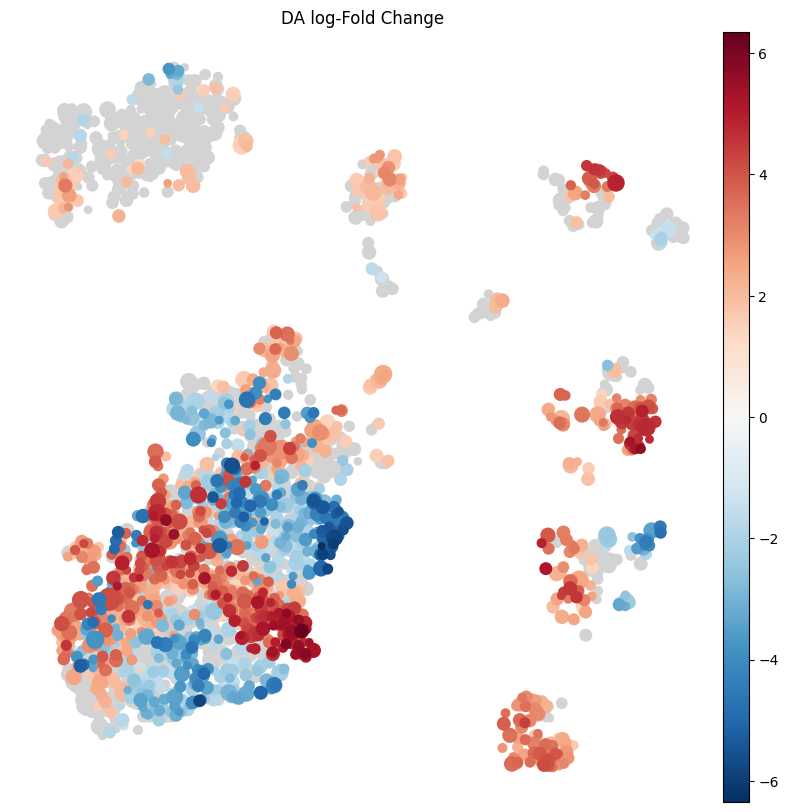

In [241]:
plt.rcParams['figure.figsize'] = [10,10]
milopy.plot.plot_nhood_graph(query_adata, min_size=1, alpha=0.01)

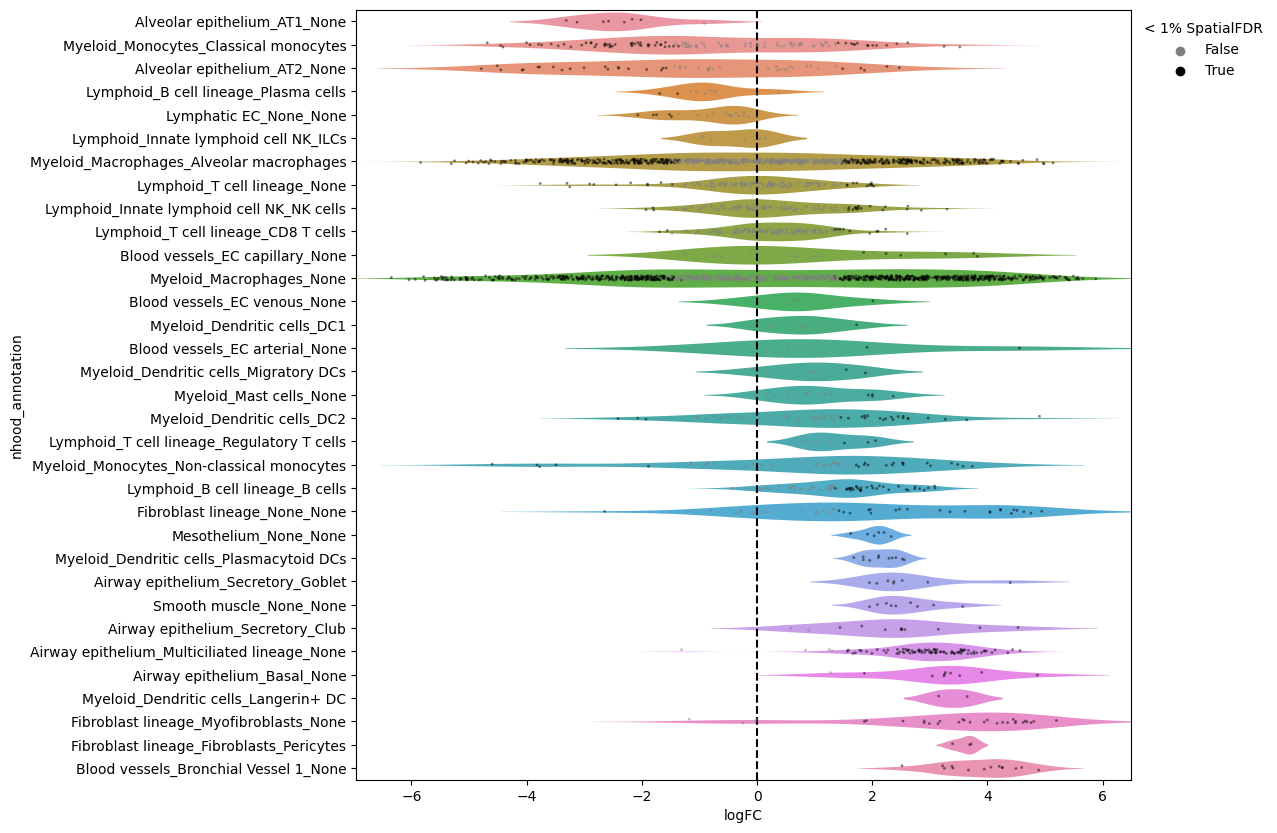

In [242]:
plt.rcParams['figure.figsize'] = [10,10]
milopy.plot.plot_DA_beeswarm(query_adata, alpha=0.01)

In [251]:
query_adata.uns['nhood_adata'].uns['annotation_labels'] = query_adata.uns['nhood_adata'].uns['annotation_labels'].tolist()

In [252]:
query_adata.uns['nhood_adata'].write_h5ad(data_dir + "Kaminski_2020_emb_LCAv2.annotated.nhood_adata.IPFvsControl.h5ad")

### Test COPD vs Control

In [253]:
milopy.core.DA_nhoods(query_adata, design='~condition', model_contrasts='conditionCOPD-conditionControl')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


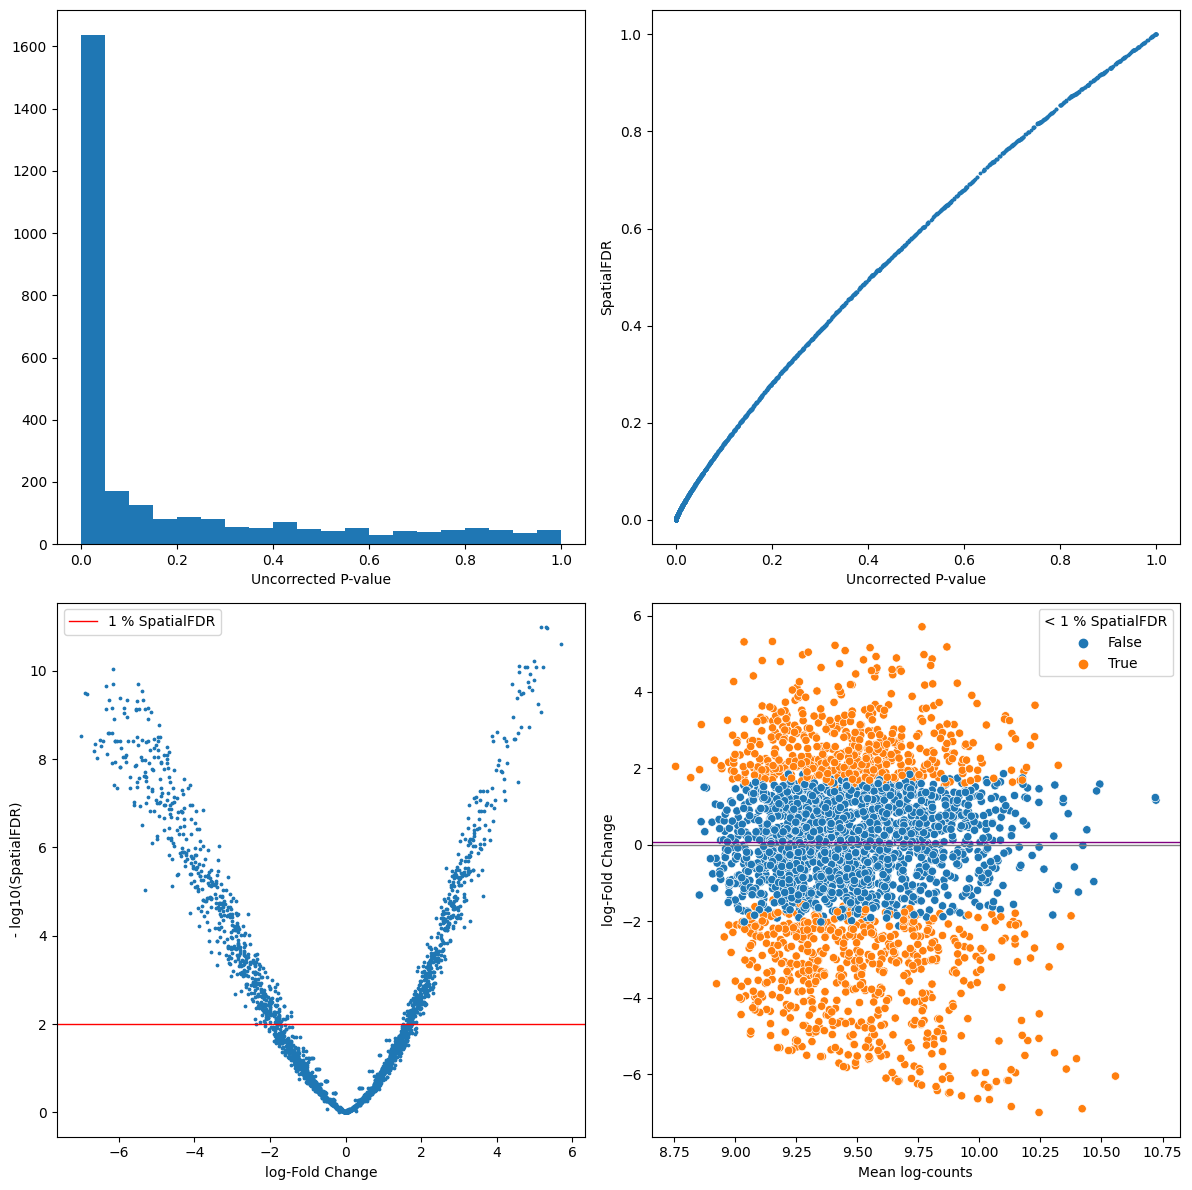

In [254]:
plot_milo_diagnostics(query_adata, alpha=0.01)

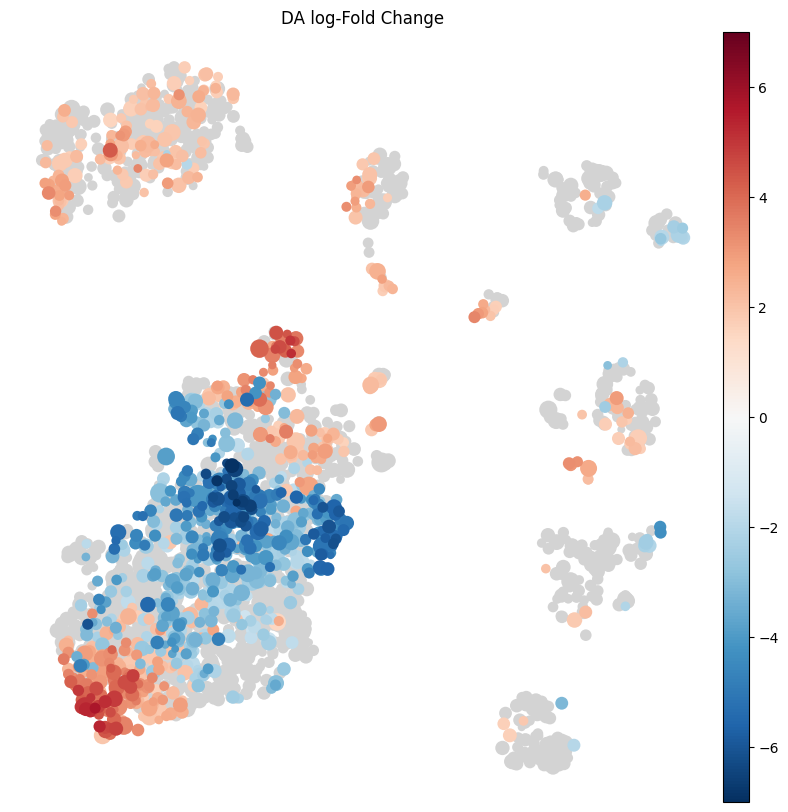

In [255]:
plt.rcParams['figure.figsize'] = [10,10]
milopy.plot.plot_nhood_graph(query_adata, min_size=1, alpha=0.01)

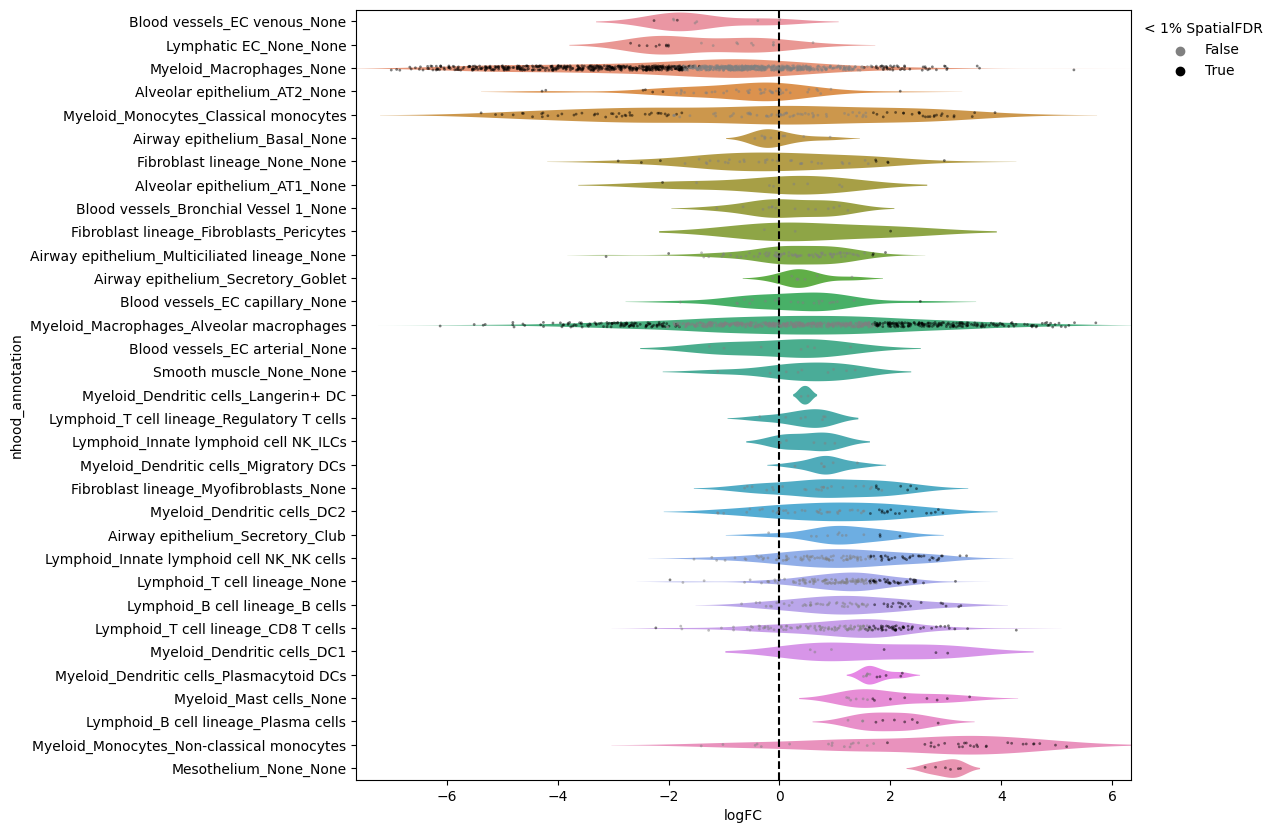

In [256]:
plt.rcParams['figure.figsize'] = [10,10]
milopy.plot.plot_DA_beeswarm(query_adata, alpha=0.01)

In [257]:
query_adata.uns['nhood_adata'].write_h5ad(data_dir + "Kaminski_2020_emb_LCAv2.annotated.nhood_adata.COPDvsControl.h5ad")

In [258]:
nhood_adata_IPF = sc.read_h5ad(data_dir + "Kaminski_2020_emb_LCAv2.annotated.nhood_adata.IPFvsControl.h5ad")
nhood_adata_COPD = sc.read_h5ad(data_dir + "Kaminski_2020_emb_LCAv2.annotated.nhood_adata.COPDvsControl.h5ad")

In [261]:
milo_res = nhood_adata_IPF.obs.copy()
milo_res['logFC_COPD'] = nhood_adata_COPD.obs['logFC'].copy()
milo_res['SpatialFDR_COPD'] = nhood_adata_COPD.obs['SpatialFDR'].copy()

In [265]:
%%R -i milo_res
head(milo_res)

                   index_cell kth_distance
0 001C_ACGATACAGTTCGCGC_adams     1.615315
1 001C_AGGCCACAGGGATACC_adams     1.725226
2 001C_CAACCTCAGAGTTGGC_adams     1.205959
3 001C_CGAACATTCTCTGCTG_adams     1.592720
4 001C_CGGACGTGTCCATGAT_adams     1.255265
5 001C_CTCGTACTCGGTCCGA_adams     2.042027
                           nhood_annotation nhood_annotation_frac      logFC
0     Myeloid_Monocytes_Classical monocytes             0.9411765 -0.6246151
1     Myeloid_Monocytes_Classical monocytes             0.9369369 -1.1417096
2 Lymphoid_Innate lymphoid cell NK_NK cells             0.9636363  0.1149564
3     Myeloid_Monocytes_Classical monocytes             1.0000000  1.1340868
4 Lymphoid_Innate lymphoid cell NK_NK cells             0.8518519  0.8582892
5              Alveolar epithelium_AT2_None             0.5769231  0.3563642
    logCPM          F     PValue        FDR SpatialFDR Nhood_size  logFC_COPD
0 9.430462 1.47741887 0.22592022 0.28327304 0.28923835        275 -1.90378343
1 9.

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


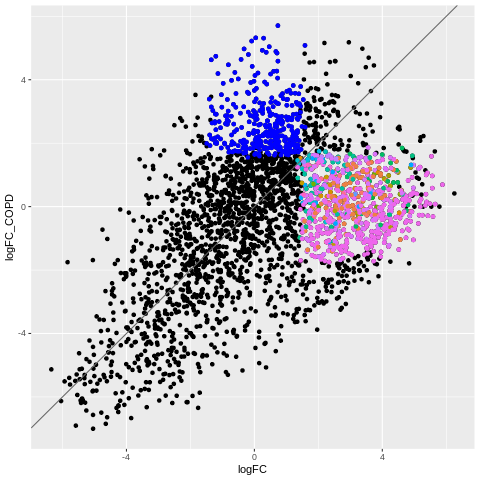

In [286]:
%%R -o pl_df
pl_df <- milo_res %>%
mutate(IPF_specific = ifelse((SpatialFDR < 0.01 & logFC > 0) & (SpatialFDR_COPD >= 0.01), as.character(nhood_annotation), NA)) %>%
mutate(COPD_specific = ifelse((SpatialFDR >= 0.01) & (SpatialFDR_COPD < 0.01 & logFC_COPD > 0), as.character(nhood_annotation), NA)) 

pl_df %>%
ggplot(aes(logFC, logFC_COPD)) + 
geom_point() +
geom_point(data=. %>% filter(!is.na(IPF_specific)), aes(color = as.character(IPF_specific))) +
geom_point(data=. %>% filter(!is.na(COPD_specific)), color='blue') +
geom_abline(color='grey40') +
guides(color='none')


In [294]:
COPD_mac_nhoods = pl_df[pl_df['COPD_specific'] == 'Myeloid_Macrophages_Alveolar macrophages'].index
IPF_mac_nhoods = pl_df[pl_df['IPF_specific'] == 'Myeloid_Macrophages_Alveolar macrophages'].index

In [319]:
COPD_mac_cells = query_adata.obs_names[query_adata.obsm['nhoods'].toarray()[:,COPD_mac_nhoods.astype('int')].sum(1) == 1]
IPF_mac_cells = query_adata.obs_names[query_adata.obsm['nhoods'].toarray()[:,IPF_mac_nhoods.astype('int')].sum(1) == 1]

In [326]:
## Check overlap between two subsets
COPD_mac_cells.isin(IPF_mac_cells).sum()/COPD_mac_cells.shape[0]
IPF_mac_cells.isin(COPD_mac_cells).sum()/IPF_mac_cells.shape[0]

0.09187352655664956

In [288]:
pl_df['IPF_specific'].value_counts()

NA_character_                                   2138
Myeloid_Macrophages_None                         300
Myeloid_Macrophages_Alveolar macrophages         149
Airway epithelium_Multiciliated lineage_None      80
Lymphoid_B cell lineage_B cells                   26
Fibroblast lineage_Myofibroblasts_None            19
Fibroblast lineage_None_None                      17
Blood vessels_Bronchial Vessel 1_None             14
Myeloid_Dendritic cells_DC2                       14
Smooth muscle_None_None                            9
Airway epithelium_Basal_None                       9
Lymphoid_Innate lymphoid cell NK_NK cells          9
Airway epithelium_Secretory_Goblet                 8
Airway epithelium_Secretory_Club                   7
Myeloid_Dendritic cells_Plasmacytoid DCs           6
Blood vessels_EC capillary_None                    5
Alveolar epithelium_AT2_None                       4
Lymphoid_T cell lineage_None                       4
Lymphoid_T cell lineage_CD8 T cells           

Potentially of interest:
- Different subsets of alveolar macrophages enriched in COPD and IPF

In [164]:
## Set query and control
# query_adata_test = query_adata.copy()
# query_adata_test.obs['dataset_group'] = np.nan
# query_adata_test.obs.loc[query_adata_test.obs['condition'] == 'IPF','dataset_group'] = 'query'
# query_adata_test.obs.loc[query_adata_test.obs['condition'] == 'Control','dataset_group'] = 'ctrl'
# query_adata_test[~query_adata_test.obs['dataset_group'].isna()]
# run_milo(query_adata, 
#          query_group='query', 
#          reference_group='ctrl',
#          sample_col='sample',
#          annotation_col='original_ann_combined',
#          design = '~subject_ID+is_query'
#         )

View of AnnData object with n_obs × n_vars = 239707 × 30
    obs: 'sample', 'subject_ID', 'condition', 'sample_type', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_nonharmonized', 'ann_level_1_core_transferred', 'ann_level_2_core_transferred', 'ann_level_3_core_transferred', 'ann_level_4_core_transferred', 'ann_level_5_core_transferred', 'original_ann_combined', 'dataset_group'
    uns: 'dataset_metadata', 'neighbors', 'umap', 'original_ann_level_3_colors', 'original_ann_level_4_colors', 'original_ann_level_2_colors', 'subject_ID_colors'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'distances', 'connectivities'

In [ ]:
query_adata.uns['nhood_adata']

---

## Compare to AR
(original paper analysis)

In [30]:
adata_all = sc.read_h5ad('/lustre/scratch117/cellgen/team205/ed6/HLCA/HLCA_v1_extended_raw_counts_2000hvgs.h5ad', backed=True)

In [48]:
adata_all[adata_all.obs['study'] == 'Kaminski_2020'].obs['ann_level_2_core_transferred']

001C_AAACCTGCATCGGGTC_adams               Myeloid
001C_AAACCTGTCAACACCA_adams               Myeloid
001C_AAACCTGTCACAGTAC_adams              Lymphoid
001C_AAACCTGTCTGTCTAT_adams               Myeloid
001C_AAACGGGAGACTAAGT_adams          Lymphatic EC
                                      ...        
8CO_TTGTAGGCATCACGTA_adams               Lymphoid
8CO_TTGTAGGTCCAGATCA_adams                Myeloid
8CO_TTTATGCGTAGGCTGA_adams          Blood vessels
8CO_TTTGGTTTCTGCAAGT_adams                Myeloid
8CO_TTTGTCAAGCCCTAAT_adams     Fibroblast lineage
Name: ann_level_2_core_transferred, Length: 307650, dtype: category
Categories (11, object): ['Airway epithelium', 'Alveolar epithelium', 'Blood vessels', 'Fibroblast lineage', ..., 'Myeloid', 'Smooth muscle', 'Submucosal Gland', 'Unknown']

In [42]:
adata_all[adata_all.obs['study'] == 'Kaminski_2020'].obs['condition'].value_counts()

IPF        144404
Control     95303
COPD        67943
Name: condition, dtype: int64

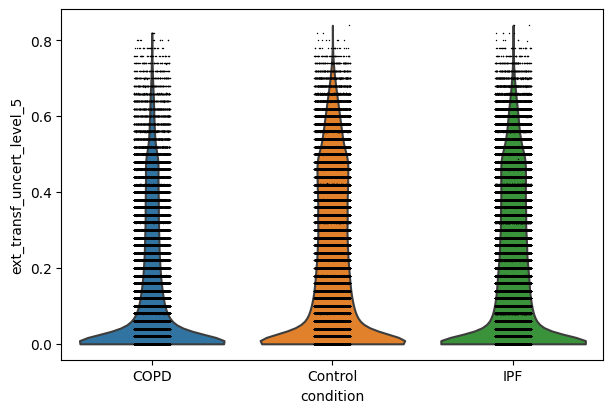

In [56]:
sc.pl.violin(adata_all[adata_all.obs['study'] == 'Kaminski_2020'].to_memory(), 'ext_transf_uncert_level_5', groupby='condition')